In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from itertools import product
from sklearn.metrics import r2_score
import csv
from vme import VME
from envelope import spline_envelope

In [2]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# импорт временного ряда

In [3]:
DS = pd.read_csv("KwhConsumptionBlower78_1.csv", decimal=',')
DS['datetime'] = pd.to_datetime(DS['TxnDate'].astype(str) + ' ' + DS['TxnTime'].astype(str))
DS['Consumption'] = pd.to_numeric(DS['Consumption'])
DS.set_index("datetime", inplace=True)
DS.dropna(inplace=True)
TS = DS['Consumption']
TS = TS.sort_index()
TS

datetime
2022-01-01 00:22:28     1.030
2022-01-01 00:42:33     0.904
2022-01-01 01:01:51     0.904
2022-01-01 01:41:48     1.850
2022-01-01 02:22:52     1.878
                        ...  
2022-01-20 22:04:41     5.732
2022-01-20 22:26:36     5.928
2022-01-20 22:47:26     6.432
2022-01-20 23:27:57    13.092
2022-01-20 23:47:55     6.788
Name: Consumption, Length: 1228, dtype: float64

In [4]:
index = TS.index
index

DatetimeIndex(['2022-01-01 00:22:28', '2022-01-01 00:42:33',
               '2022-01-01 01:01:51', '2022-01-01 01:41:48',
               '2022-01-01 02:22:52', '2022-01-01 02:47:00',
               '2022-01-01 03:06:30', '2022-01-01 03:27:40',
               '2022-01-01 03:47:47', '2022-01-01 04:07:36',
               ...
               '2022-01-20 20:21:01', '2022-01-20 20:44:24',
               '2022-01-20 21:03:39', '2022-01-20 21:24:09',
               '2022-01-20 21:43:55', '2022-01-20 22:04:41',
               '2022-01-20 22:26:36', '2022-01-20 22:47:26',
               '2022-01-20 23:27:57', '2022-01-20 23:47:55'],
              dtype='datetime64[ns]', name='datetime', length=1228, freq=None)

In [5]:
k = 4 # количество декомпозиций
f = TS[::].values # значения временного ряда, в дальнейшем - вычеты
u = np.zeros(k, dtype=list) # декомпозиции
low = np.zeros(k, dtype=list) # верхние огибающие
high = np.zeros(k, dtype=list) # нижние огибающие


for i in range(0,k):
    low_envelope, high_envelope = spline_envelope(f,dmin=1,dmax=1)
    low[i] = low_envelope
    high[i] = high_envelope
    # u[i] = (high_envelope + low_envelope)/2
    u[i] = f - (high_envelope + low_envelope)/2
    f = f - u[i]

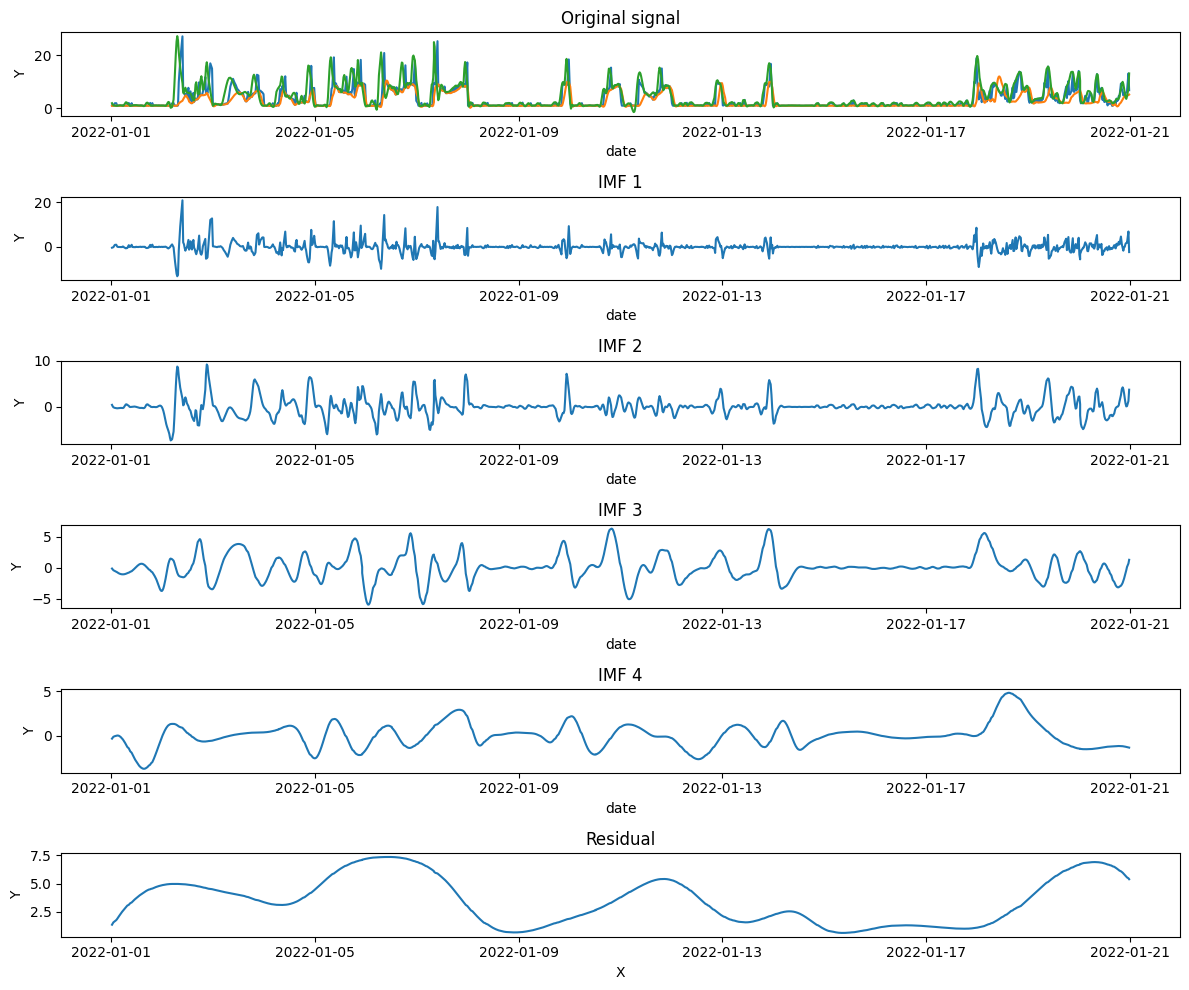

In [6]:
fig, axs = plt.subplots(figsize=(12,10), nrows=k+2)

# plt.subplot(2,1,1)
axs[0].set(xlabel = 'date', ylabel='Y')
axs[0].plot(index, TS[::].values)
axs[0].plot(index, low[0])
axs[0].plot(index, high[0])
axs[0].set_title('Original signal')

# plt.subplot(2,1,2)
for i in range(k):
    axs[i+1].plot(index, u[i])
    axs[i+1].set_title(f'IMF {i+1}')
    axs[i+1].set(xlabel = 'date', ylabel='Y')

# plt.subplot(2,2,2)
axs[k+1].plot(index, f)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

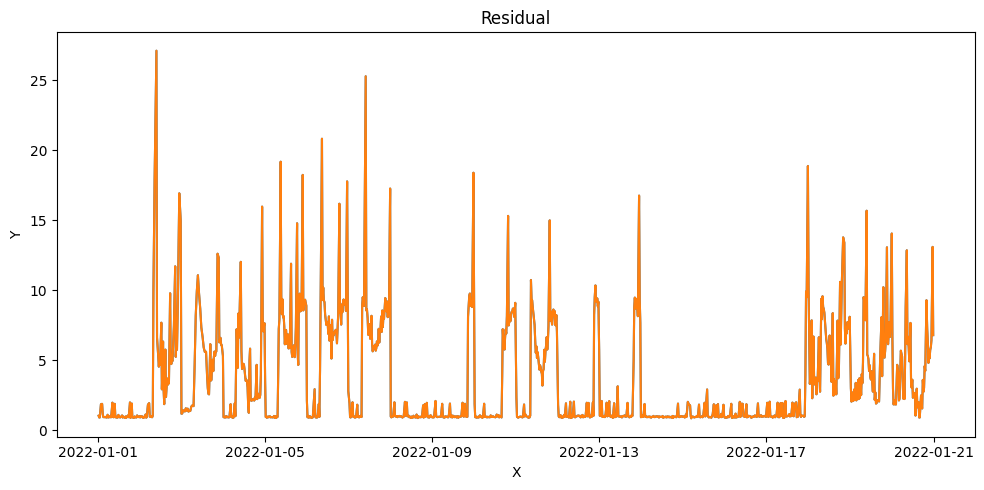

In [7]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)


sum_imfs = 0
for i in range(0,k):
    sum_imfs += u[i]

sum_imfs += f
axs.plot(index, TS[::].values)
axs.plot(index, sum_imfs)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

In [8]:
Trend = f + u[3]
Season = u[2]+u[1]
Noise = u[0]

# тестовый анализ

In [60]:
#. some sample parameters for VMD
alpha = (500, 1000) # moderate bandwidth constraint
tau = 0 # noise-tolerance (no strict fidelity enforcement)
tol = 1e-6
fs = 10
omega_init = (1, 10)

f = TS[1].reshape((1500,))
sum_imfs = 0
featurecount = 6

criteria = np.zeros(len(alpha)*len(omega_init), dtype=float)
j = 0

In [61]:
list(product(alpha, omega_init))

[(500, 1), (500, 10), (1000, 1), (1000, 10)]

In [62]:
for params_set in list(product(alpha, omega_init)):
    u, u_hat, omega = VME(f, params_set[0], params_set[1], fs, tau, tol)
    criteria[j] = r2_score(f, u.T.real + sum_imfs)
    j += 1

In [63]:
criteria

array([ 0.92248508, -0.08126547,  0.7038971 , -0.08147797])

In [64]:
np.argmax(criteria)

np.int64(0)

In [65]:
np.max(criteria)

np.float64(0.9224850750959839)

In [72]:
list(product(alpha, omega_init))[np.argmax(criteria)][1]

1

Text(0.5, 0, 'X')

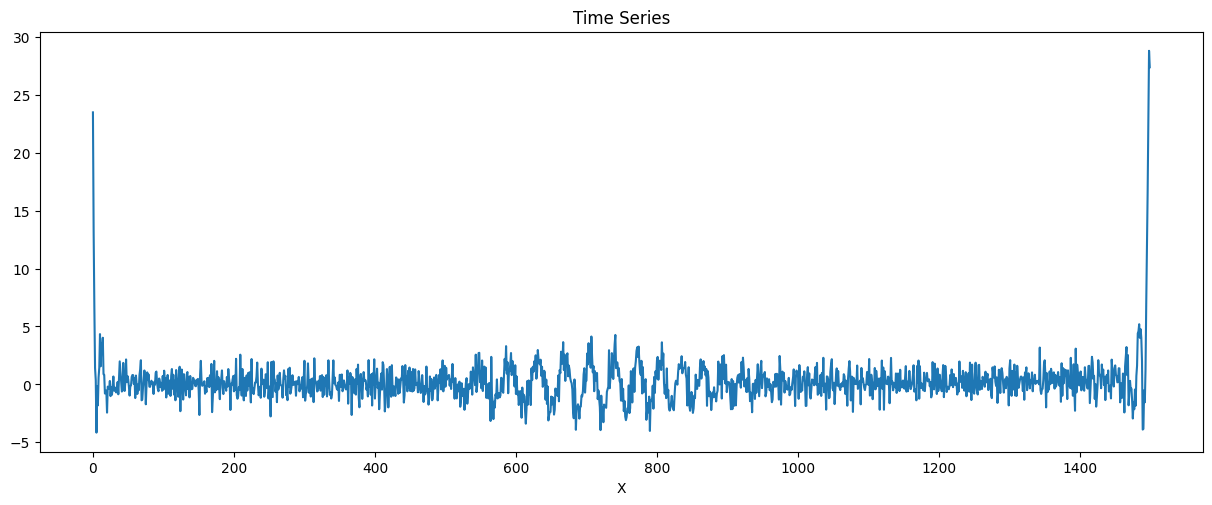

In [27]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], f)
plt.title('Time Series')
plt.xlabel('X')

C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'X')

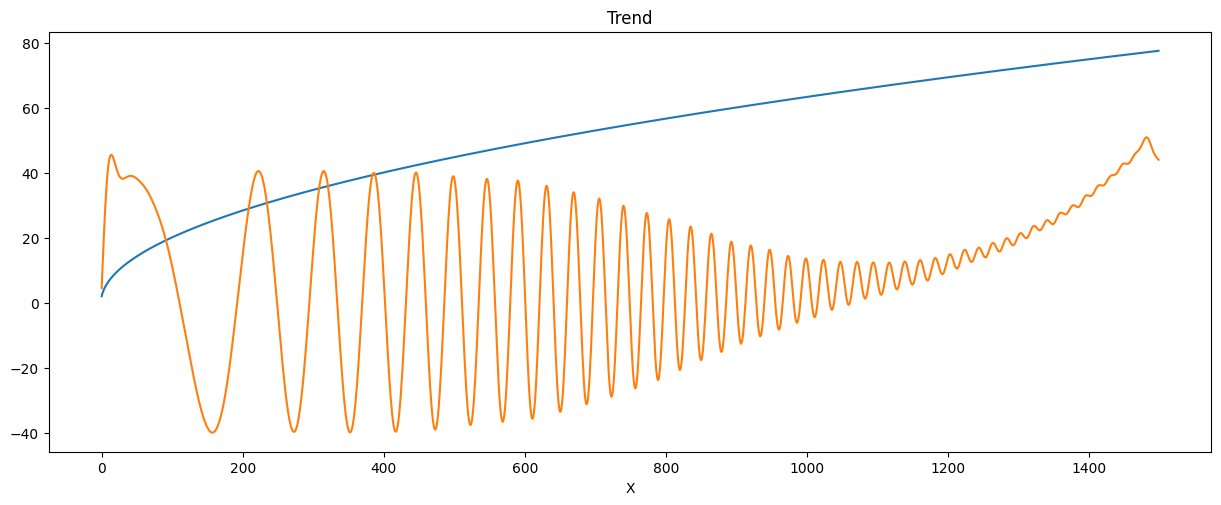

In [28]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], Trend[0])
plt.plot(index[0], u1.T)
plt.title('Trend')
plt.xlabel('X')

In [29]:
Trend[1]

0        0.030150
1        0.030302
2        0.030453
3        0.030606
4        0.030759
          ...    
1495    53.167223
1496    53.433725
1497    53.701563
1498    53.970743
1499    54.241272
Name: Value, Length: 1500, dtype: float64

In [30]:
u.T

array([18.17208935+0.j, 26.23666187+0.j, 32.77041666+0.j, ...,
       62.54522181+0.j, 65.48412422+0.j, 65.30661156+0.j], shape=(1500,))

In [31]:
r2_score(Trend[1], u1.T.real)

-1.8855880403623542

Text(0.5, 0, 'X')

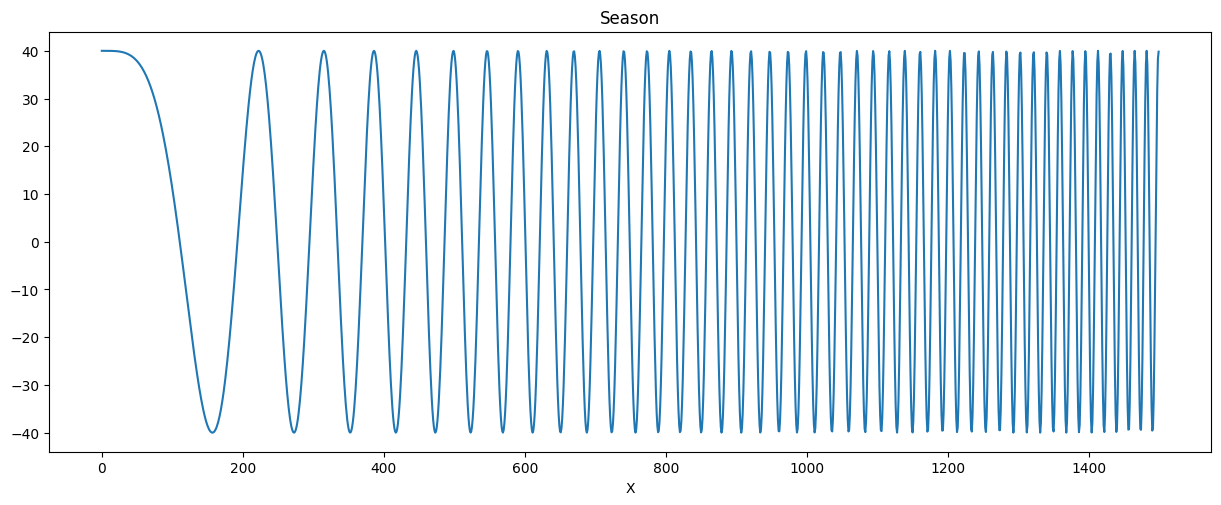

In [32]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], Season)
plt.title('Season')
plt.xlabel('X')

C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


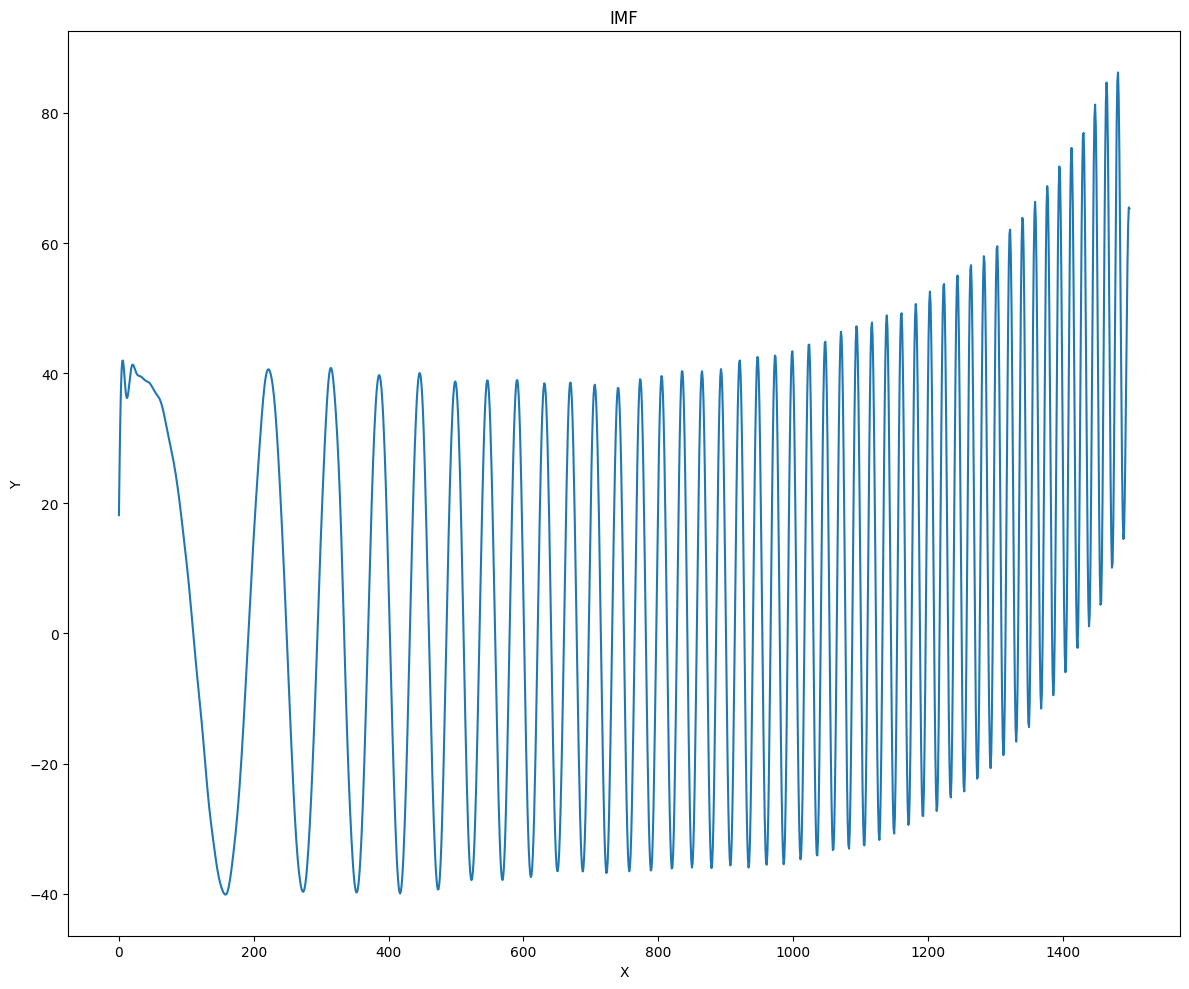

In [33]:
# plt.figure(figsize=(15,12))
# plt.subplot(2,1,1)
# plt.plot(index[0], TS[0])

fig, axs = plt.subplots(figsize=(12,10), nrows=1)

# axs[0].set(xlabel = 'date', ylabel='C')
# plt.subplot(2,2,1)
axs.plot(index[0], u.T)
axs.set_title(f'IMF {i+1}')

plt.title('IMF')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

# Тренд

In [10]:
# набор параметров
alpha = (0, 500, 1000, 5000, 10000, 20000) # moderate bandwidth constraint
omega_init = (1, 501, 1001, 5001, 10001)
fs = 20000
tau = (0, 1, 2, 3) # noise-tolerance (no strict fidelity enforcement)
tol = 1e-6
params_set = list(product(alpha, omega_init, tau))

featurecount = 5

MetricName = "BIC"
maxmin = lambda criteria: np.min(criteria)
arg_maxmin = lambda criteria: np.argmin(criteria)
default_value = np.inf

In [12]:
best_params = np.zeros(5, dtype=dict)
criteria = np.zeros(len(alpha)*len(omega_init)*len(tau), dtype=float)

In [13]:
best_metriks = {"Time Series": "Delhi temerature", f"{MetricName}": default_value}

best_params[0] = {"Time Series": "Delhi temerature", "IMFs" : "1", "Metric": f"{MetricName}", "alpha": 0, "tau": 0, "W init": False, "fs": fs, "tol": 1e-6}
for j in range(1,5):
    best_params[j] = {"Time Series": "Delhi temerature", "IMFs" : f"1 - {j+1}", "Metric": f"{MetricName}", "alpha": 0, "W init": False, "fs": fs, "tau": 0, "tol": 1e-6}

In [14]:
f = TS.values
k_i = 0

best_imfs = 0
sum_imfs = 0
isbest_params = True

while((k_i<5) and isbest_params):
    isbest_params = False
    criteria.fill(0)
    j=0
    # для всех наборов параметров
    for params_i in params_set:
        u, u_hat, omega = VME(f, params_i[0], params_i[1], fs, params_i[2], tol)

        criteria[j] = calculate_bic(Trend, u.T.real + sum_imfs, featurecount)
        j += 1
    
    max_criteria = maxmin(criteria)
    argmax_criteria = arg_maxmin(criteria)
    if (max_criteria < best_metriks[f"{MetricName}"]):
        best_metriks[f"{MetricName}"] = max_criteria

        best_params[k_i]["IMFs"] = f'1 - {k_i+1}'
        best_params[k_i]["alpha"] = params_set[argmax_criteria][0]
        best_params[k_i]["W init"] = params_set[argmax_criteria][1]
        best_params[k_i]["tau"] = params_set[argmax_criteria][2]
        
        u, _, _ = VME(f, best_params[k_i]["alpha"], best_params[k_i]["W init"], \
                            fs, best_params[k_i]["tau"], tol)
        best_imfs = u.T.real
        isbest_params = True
    
    k_i+=1
    sum_imfs += best_imfs
    if(isbest_params):
        f = f - best_imfs

In [15]:
filename=f".\Output-VME\\Best_Metriks-Trend-{MetricName}-VME.csv"

fields = best_metriks.keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows([best_metriks])  # Write data rows

In [16]:
filename=f".\Output-VME\\Parameters-Trend-{MetricName}-VME.csv"

fields = best_params[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    for j in range(5):
        writer.writerows([best_params[j]])  # Write data rows

# Сезон

In [17]:
best_metriks = {"Time Series": "Delhi temerature", f"{MetricName}": default_value}

best_params[0] = {"Time Series": "Delhi temerature", "IMFs" : f"{k_i}", "Metric": f"{MetricName}", "alpha": 0, "tau": 0, "W init": False, "fs": 0, "tol": 1e-6}
for j in range(k_i,5):
    best_params[j] = {"Time Series": "Delhi temerature", "IMFs" : f"{k_i} - {j+1}", "Metric": f"{MetricName}", "alpha": 0, "W init": False, "fs": 0, "tau": 0, "tol": 1e-6}

In [18]:
season_k = k_i
    
best_imfs = 0
sum_imfs = 0
isbest_params = True

while((k_i<5) and isbest_params):
    isbest_params = False
    criteria.fill(0)
    j=0
    # для всех наборов параметров
    for params_i in params_set:
        u, u_hat, omega = VME(f, params_i[0], params_i[1], fs, params_i[2], tol)

        criteria[j] = calculate_bic(Season, u.T.real + sum_imfs, featurecount)
        j += 1
    
    max_criteria = maxmin(criteria)
    argmax_criteria = arg_maxmin(criteria)
    if (max_criteria < best_metriks[f"{MetricName}"]):
        best_metriks[f"{MetricName}"] = max_criteria

        best_params[k_i]["IMFs"] = f'{season_k} - {k_i+1}'
        best_params[k_i]["alpha"] = params_set[argmax_criteria][0]
        best_params[k_i]["W init"] = params_set[argmax_criteria][1]
        best_params[k_i]["tau"] = params_set[argmax_criteria][2]
        
        u, _, _ = VME(f, best_params[k_i]["alpha"], best_params[k_i]["W init"], \
                            fs, best_params[k_i]["tau"], tol)
        best_imfs = u.T.real
        isbest_params = True
    
    k_i+=1
    sum_imfs += best_imfs
    if(isbest_params):
        f = f - best_imfs

In [19]:
filename=f".\Output-VME\\Best_Metriks-Season-{MetricName}-VME.csv"

fields = best_metriks.keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows([best_metriks])  # Write data rows

In [20]:
filename=f".\Output-VME\\Parameters-Season-{MetricName}-VME.csv"

fields = best_params[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    for j in range(season_k, 5):
        writer.writerows([best_params[j]])  # Write data rows

# Шум

In [21]:
best_metriks = {"Time Series": "Delhi temerature", f"{MetricName}": default_value}

In [22]:
criteria = calculate_bic(Noise, f, featurecount)
if (criteria < best_metriks[f"{MetricName}"]):
    best_metriks[f"{MetricName}"] = criteria

In [23]:
filename=f".\Output-VME\\Best_Metriks-Noise-{MetricName}-VME.csv"

fields = best_metriks.keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows([best_metriks])  # Write data rows

# ШУМ freguency

In [24]:
best_metriks = {"Time Series": "Delhi temerature", f"{MetricName}": default_value}

In [25]:
original_noise = np.abs(np.fft.rfft(Noise))

imf_freg = np.abs(np.fft.rfft(f.astype(float)))

criteria = calculate_bic(original_noise, imf_freg, featurecount)
if (criteria < best_metriks[f"{MetricName}"]):
    best_metriks[f"{MetricName}"] = criteria

In [26]:
filename=f".\Output-VME\\Best_Metriks-Noise-freg-{MetricName}-VME.csv"

fields = best_metriks.keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows([best_metriks])  # Write data rows